# HW6 Comprehensive Supervised Learning
Contributors: Zongyu Wu, Tony Wilson, Chandler Smith

Summary: The overall purpose of this assignment is to tie together a variety of supervised learning techniques in order to appropriately analyze several questions related to the Behavioral Risk Factor Surveillance System. More specifically, the goal is to use supervised ML to identify patterns of comorbidity among the survey respondents. This is a comparative exercise focusing on pre (2019) and post (2021) covid health. 

Notes from discussion:

Approach: One approach for understanding behavioral factors behind comorbidity is to apply classification algorithms to the BRFSS data. Such algorithms can be trained to predict whether an individual has multiple chronic conditions based on their responses to the survey questions. By analyzing the features that are most important for predicting comorbidity, one can identify risk factors and inform the development of targeted prevention and intervention strategies.

Response related:
Depression = ADDEPEV3
 Ever told Asthma = _CASTHM1
 COPD = (CHCCOPD2 for 2019 and CHCCOPD3 for 2021)
 Cancer = (combine CHCSCNCR and CHCOCNCR)
 Ever told Heart Condition = combination of CVDCRHD4, CVDINFR4 and CVDSTRK3
 Diabetes = DIABETE4
 

Key demographic features:
Age: _AGE_G
 Marital: MARITAL
 Sex: _SEX
 Income: INCOME2
 Education: _EDUCAG

- Do NOT refer to correlation
- BRFSS data can be used to understand comorbidity, which refers to the presence of multiple chronic conditions in an individual. 
- RFSS uses a complex sampling and weighting scheme to measure prevalence of many health conditions, behavioral and lifestyle related risk factors and emerging health issues in states. 
- Do not use the weight variable as we are conducting estimations. 


- 2019 Codebook: https://www.cdc.gov/brfss/annual_data/2019/pdf/codebook19_llcp-v2-508.HTML
- 2021 Codebook: https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf

## Clean, Standardize, and Merge data


In [161]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

import sklearn 

# Libraries related to outlier detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

from sklearn import datasets
import random
import seaborn as sns
import matplotlib.pyplot as plt
#import missingno as msno
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore') 
sns.set(rc={'figure.figsize':(11,8)})

pd.options.display.float_format = '{:.2f}'.format

## <font color= darkgreen> Basic EDA

### <font color= lightblue> Step 1: Read the data and merge into Pandas Data Frame

In [162]:
###############################################################################################################################################################################
'''                                                                       Data Frame Setup                                                                                  '''
###############################################################################################################################################################################
## The first column is index: skipping that column to end read csv to Panda Data Frame
df_21 = pd.read_csv("/Users/chandlersmith/Desktop/brfss21-1.csv")
df_21.drop(columns="Unnamed: 0", inplace=True)
df_21.head()



,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_FRTRES1,_VEGRES1,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1
0,1.00,1.00,b'01192021',b'01',b'19',b'2021',1100.00,b'2021000001',2021000001.00,1.00,...,1.00,1.00,100.00,214.00,1.00,1.00,1.00,1.00,0.00,0.00
1,1.00,1.00,b'01212021',b'01',b'21',b'2021',1100.00,b'2021000002',2021000002.00,1.00,...,1.00,1.00,100.00,128.00,1.00,1.00,1.00,1.00,0.00,0.00
2,1.00,1.00,b'01212021',b'01',b'21',b'2021',1100.00,b'2021000003',2021000003.00,1.00,...,1.00,1.00,100.00,71.00,1.00,2.00,1.00,1.00,0.00,0.00
3,1.00,1.00,b'01172021',b'01',b'17',b'2021',1100.00,b'2021000004',2021000004.00,1.00,...,1.00,1.00,114.00,165.00,1.00,1.00,1.00,1.00,0.00,0.00
4,1.00,1.00,b'01152021',b'01',b'15',b'2021',1100.00,b'2021000005',2021000005.00,1.00,...,1.00,1.00,100.00,258.00,1.00,1.00,1.00,1.00,0.00,0.00


In [163]:
df_19 = pd.read_csv("/Users/chandlersmith/Desktop/brfss19-1.csv")
df_19.drop(columns="Unnamed: 0", inplace= True)
df_19.head()


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1,_FLSHOT7,_PNEUMO3,_AIDTST4
0,1,1,1182019,1,18,2019,1100,2019000001,2019000001,1.00,...,114.00,1,1,1,1,0,0,2.00,1.00,2.00
1,1,1,1132019,1,13,2019,1100,2019000002,2019000002,1.00,...,121.00,1,1,1,1,0,0,1.00,1.00,2.00
2,1,1,1182019,1,18,2019,1100,2019000003,2019000003,1.00,...,164.00,1,1,1,1,0,0,1.00,2.00,2.00
3,1,1,1182019,1,18,2019,1200,2019000004,2019000004,1.00,...,NaN,9,9,1,1,1,1,9.00,9.00,NaN
4,1,1,1042019,1,4,2019,1100,2019000005,2019000005,1.00,...,178.00,1,1,1,1,0,0,2.00,1.00,2.00


### <font color= lightblue> Step 2: Summary of Stats

In [164]:
###############################################################################################################################################################################
'''                                                                    Data Frame Description                                                                               '''
###############################################################################################################################################################################
df_19.describe()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1,_FLSHOT7,_PNEUMO3,_AIDTST4
count,418268.00,418268.00,418268.00,418268.00,418268.00,418268.00,418268.00,418268.00,418268.00,149941.00,...,364838.00,418268.00,418268.00,418268.00,418268.00,418268.00,418268.00,159112.00,159112.00,377977.00
mean,29.62,6.54,6727352.51,6.58,14.53,2019.04,1117.44,2019004884.52,2019004884.52,1.00,...,204.14,2.19,2.19,1.00,1.00,0.11,0.13,2.23,2.37,1.97
std,16.15,3.34,3304672.99,3.31,8.49,0.21,37.95,3653.32,3653.32,0.00,...,267.90,2.40,2.63,0.04,0.05,0.32,0.35,2.47,2.73,1.56
min,1.00,1.00,1012020.00,1.00,1.00,2019.00,1100.00,2019000001.00,2019000001.00,1.00,...,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
25%,18.00,4.00,4082019.00,4.00,7.00,2019.00,1100.00,2019002011.00,2019002011.00,1.00,...,114.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00
50%,27.00,7.00,7012019.00,7.00,14.00,2019.00,1100.00,2019004137.00,2019004137.00,1.00,...,165.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,2.00
75%,42.00,9.00,9302019.00,9.00,22.00,2019.00,1100.00,2019006895.00,2019006895.00,1.00,...,229.00,2.00,2.00,1.00,1.00,0.00,0.00,2.00,2.00,2.00
max,72.00,12.00,12312019.00,12.00,31.00,2020.00,1200.00,2019017419.00,2019017419.00,1.00,...,13204.00,9.00,9.00,1.00,1.00,2.00,2.00,9.00,9.00,9.00


In [165]:
###############################################################################################################################################################################
'''                                                                     Data Frame Shape                                                                                    '''
###############################################################################################################################################################################
df_19.shape

(418268, 250)

In [166]:
###############################################################################################################################################################################
'''                                                                    Data Frame Description                                                                               '''
###############################################################################################################################################################################
df_21.describe()

,_STATE,FMONTH,DISPCODE,_PSU,CTELENM1,PVTRESD1,COLGHOUS,STATERE1,LADULT1,COLGSEX,...,_FRTRES1,_VEGRES1,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1
count,438693.00,438693.00,438693.00,438693.00,117786.00,117786.00,30.00,117786.00,117786.00,30.00,...,438693.00,438693.00,387606.00,378566.00,438693.00,438693.00,438693.00,438693.00,438693.00,438693.00
mean,30.74,6.41,1118.19,2021006064.89,1.00,1.00,1.00,1.00,1.01,1.63,...,0.88,0.86,178.34,271.54,2.27,2.26,0.99,0.99,0.13,0.15
std,15.33,3.42,38.58,6383.75,0.00,0.02,0.00,0.00,0.08,0.49,...,0.32,0.34,691.29,1036.23,2.49,2.71,0.07,0.09,0.35,0.38
min,1.00,1.00,1100.00,2021000001.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,20.00,3.00,1100.00,2021002091.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,57.00,114.00,1.00,1.00,1.00,1.00,0.00,0.00
50%,31.00,6.00,1100.00,2021004338.00,1.00,1.00,1.00,1.00,1.00,2.00,...,1.00,1.00,100.00,167.00,1.00,1.00,1.00,1.00,0.00,0.00
75%,41.00,9.00,1100.00,2021007674.00,1.00,1.00,1.00,1.00,1.00,2.00,...,1.00,1.00,200.00,229.00,2.00,2.00,1.00,1.00,0.00,0.00
max,78.00,12.00,1200.00,2021039095.00,2.00,2.00,1.00,1.00,2.00,2.00,...,1.00,1.00,19800.00,39600.00,9.00,9.00,1.00,1.00,2.00,2.00


In [167]:
###############################################################################################################################################################################
'''                                                                     Data Frame Shape                                                                                    '''
###############################################################################################################################################################################
df_21.shape

(438693, 250)

### <font color= lightblue> Step 3: Choose Feature Space

<font color=white>We will first need to choose our feature space.  The five demographics provided will be the first on the list:
<font color= red>
* Age:  _AGE_G
* Marital: MARITAL
* Sex: _SEX
* Income: INCOME2
* Education: _EDUCAG

<font color= white>
Next we want to choose some features which we think will have some bearing on the response columns. We also want to pair the 250 features down to 20 (as per professor). Another demographic could be their race and city vs rural living as well as access to health care (insurance) and routine checkups:
<br><br>
<font color= red>

* Race: _RACE
* State: _STATE
* Urban / Rural: _METSTAT
* Health Care Access (Insurance): PRIMINSR &ensp;&ensp;&ensp;&ensp;<font color=lightblue>-- Health Insurance data not included in the data provided<font color= red>
* Health Care Access (Routine checkup): CHECKUP1

<font color= white>
Also, we should also track physical activity, High blood pressure, High Cholesterol, smoking habits, drinking habits, BMI, kidney disease
<br><br>
<font color= red>

* Physical exersice: _TOTINDA
* HBP: _RFHYPE6 &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;<font color=lightblue>-- Blood Pressure metrics not included in the data provided<font color= white><br>

Instead we will use Currently taking blood pressure medication and Be very carefull with our clean up <br><font color= red>

* High Cholesterol: _RFCHOL3 &ensp;&ensp;&ensp;&ensp;<font color=lightblue>-- Cholesterol metrics not included in the data provided<font color= red>
* Four level smoker status: _SMOKER3
* Number of drinks per week: _DRNKWK1&ensp;&ensp;&ensp;&ensp;<font color=lightblue> Continuous Data<font color= red>
* Total Fruit per Day: _FRUTSU1&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;<font color=lightblue> Continuous Data<font color= red>
* Total Vegetables per Day: _VEGESU1&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;<font color=lightblue> Continuous Data<font color= red>
* Total French Fry per Day: FRNCHDA_&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;<font color=lightblue> Continuous Data<font color= red>
* Body Mass Index: _BMI5&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;<font color=lightblue> Continuous Data<font color= red>
* Kidney Disease: CHCKDNY2

<font color= white>
The last demographic that Tony would like to include specifically is whether the participant is a veteran:
br><br>
<font color= red>

* Veteran Status: VETERAN3


In [168]:
###############################################################################################################################################################################
'''                                                               Choosing Response and Features                                                                            '''
###############################################################################################################################################################################
df_19_trim = df_19.loc[:, ['ADDEPEV3', '_CASTHM1', 'CHCCOPD2', 'CHCSCNCR', 'CHCOCNCR', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3',
                            'DIABETE4', '_AGE_G', 'MARITAL', '_SEX', 'INCOME2', '_EDUCAG', '_RACE', '_STATE', '_METSTAT', 'CHECKUP1',
                            'BPMEDS', '_TOTINDA', '_SMOKER3', '_DRNKWK1', '_FRUTSU1', '_VEGESU1','FRNCHDA_', '_BMI5', 
                            'CHCKDNY2', 'VETERAN3']]
df_19_trim.shape

(418268, 28)

In [169]:
###############################################################################################################################################################################
'''                                                               Choosing Response and Features                                                                            '''
###############################################################################################################################################################################
df_21_trim = df_21.loc[:, ['ADDEPEV3', '_CASTHM1', 'CHCCOPD3', 'CHCSCNCR', 'CHCOCNCR', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3',
                            'DIABETE4', '_AGE_G', 'MARITAL', '_SEX', 'INCOME3', '_EDUCAG', '_RACE', '_STATE', '_METSTAT', 'CHECKUP1',
                            'BPMEDS', '_TOTINDA', '_SMOKER3', '_DRNKWK1', '_FRUTSU1', '_VEGESU1','FRNCHDA_', '_BMI5', 
                            'CHCKDNY2', 'VETERAN3']]
df_21_trim.shape

(438693, 28)

### <font color= lightblue> Step 4: Missing Data Analysis

##### BPMEDS
From looking at the data itself, most of the missing values from BPMEDS is because the previous question answered something other than yes to every choice other than yes.  Therefore we can infer that these were a no and that 7 and 9 should be dropped.
* 2021-
- missing: 266,560 
<br>vs<br>
- Previous other than yes: 266,560

there is only 0.26% which was I don't know or Refused

* 2019-
- missing: 248,634 
<br>vs<br>
- Previous other than yes: 248,634

there is only 0.21% which was I don't know or Refused

In [170]:
###############################################################################################################################################################################
'''                                                                   Analyze, Clean, and Impute                                                                            '''
###############################################################################################################################################################################
## Print Original Shape for comparisson
print('Original 19 shape:\t', df_21_trim.shape)
print('Original 21 shape:\t', df_21_trim.shape)

## Interpret and clean df
# output how many NaN there is per column
print('Missing values by field (Pre-Interpolate):')

# Visualize the finished Data Frame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_19_trim.isnull().sum(), '\n')
    print(df_21_trim.isnull().sum(), '\n')

## Replace missing values in BPMEDS with No answer and drop 7 and 9 response as NAN
df_19_trim = df_19_trim[df_19_trim['BPMEDS'] != 7] 
df_19_trim = df_19_trim[df_19_trim['BPMEDS'] != 9]
df_19_trim['BPMEDS'].fillna(2, inplace= True) 

# How are we doing now
print(df_19_trim.isnull().sum(), '\n')
print(df_19_trim.shape)

# Drop the remaining NaN
df_19_trim.dropna(inplace= True)


## Replace missing values in BPMEDS with No answer and drop 7 and 9 response as NAN
df_21_trim = df_21_trim[df_21_trim['BPMEDS'] != 7] 
df_21_trim = df_21_trim[df_21_trim['BPMEDS'] != 9]
df_21_trim['BPMEDS'].fillna(2, inplace= True) 

# How are we doing now
print(df_21_trim.isnull().sum(), '\n')
print(df_21_trim.shape)

# Drop the remaining NaN
df_21_trim.dropna(inplace= True)

# Output final shape
print('Final 19 shape:\t', df_19_trim.shape)
print('Final 21 shape:\t', df_21_trim.shape)

Original 19 shape:	 (438693, 28)
Original 21 shape:	 (438693, 28)
Missing values by field (Pre-Interpolate):
ADDEPEV3        10
_CASTHM1         0
CHCCOPD2         8
CHCSCNCR         8
CHCOCNCR         9
CVDCRHD4         8
CVDINFR4        10
CVDSTRK3        11
DIABETE4         9
_AGE_G           0
MARITAL         49
_SEX             0
INCOME2       6881
_EDUCAG          0
_RACE            3
_STATE           0
_METSTAT      8458
CHECKUP1        10
BPMEDS      248634
_TOTINDA         0
_SMOKER3         0
_DRNKWK1         0
_FRUTSU1     44600
_VEGESU1     53430
FRNCHDA_     38866
_BMI5        36203
CHCKDNY2        11
VETERAN3      1374
dtype: int64 

ADDEPEV3         3
_CASTHM1         0
CHCCOPD3         3
CHCSCNCR         2
CHCOCNCR         3
CVDCRHD4         2
CVDINFR4         2
CVDSTRK3         2
DIABETE4         3
_AGE_G           0
MARITAL          5
_SEX             0
INCOME3       8847
_EDUCAG          0
_RACE            0
_STATE           0
_METSTAT      7054
CHECKUP1         2
BP

## Create categorical columns

- Column 1: Binary - indicates whether an individual has haf any of the chronic conditions. 
- Column 2: Multiclass - create a milticlass column with values that inidicate the total number of chronic conditions.

### <font color= lightblue> Step 5: Binary and Multiclass Response Created

<font color= yellow>First we create the binaries for 2019

In [171]:
###############################################################################################################################################################################
'''                                                                   Convert Response Column for 2019                                                                      '''
###############################################################################################################################################################################
## Binary Comorbidity Response Features from our respective responses
# Create the Depression comorbidity variable
df_19_trim['Depression'] = df_19_trim.apply(lambda row: 1 if row[0] == 1 else (0 if row[0] == 2 else np.NAN), axis=1)
print(df_19_trim[['Depression', 'ADDEPEV3']].value_counts())
print(df_19_trim['Depression'].isnull().sum())
print(df_19_trim['ADDEPEV3'].value_counts(), '\n')

# Create the Asthma comorbidity variable
df_19_trim['Asthma'] = df_19_trim.apply(lambda row: 1 if row[1] == 1 else (0 if row[1] == 2 else np.NAN), axis=1)
print(df_19_trim[['Asthma', '_CASTHM1']].value_counts())
print(df_19_trim['Asthma'].isnull().sum())
print(df_19_trim['_CASTHM1'].value_counts(), '\n')

# Create the COPD comorbidity variable
df_19_trim['COPD'] = df_19_trim.apply(lambda row: 1 if row[2] == 1 else (0 if row[2] == 2 else np.NAN), axis=1)
print(df_19_trim[['COPD', 'CHCCOPD2']].value_counts())
print(df_19_trim['COPD'].isnull().sum())
print(df_19_trim['CHCCOPD2'].value_counts(), '\n')

# Create the Cancer comorbidity variable
df_19_trim['Cancer'] = df_19_trim.apply(lambda row: 1 if row[3] == 1 else (1 if row[4] == 1 else (0 if row[3] == 2 else ( 0 if row[4] == 2 else np.NAN))), axis=1)
print(df_19_trim[['Cancer', 'CHCSCNCR', 'CHCOCNCR']].value_counts())
print(df_19_trim['Cancer'].isnull().sum())
print(df_19_trim['CHCSCNCR'].value_counts(), '\n')
print(df_19_trim['CHCOCNCR'].value_counts(), '\n')
print(df_19_trim['Cancer'].value_counts(), '\n')

# Create the Heart Condition comorbidity variable
df_19_trim['Heart'] = df_19_trim.apply(lambda row: 1 if row[5] == 1 else (1 if row[6] == 1 else (1 if row[7] == 1 else (0 if row[5] == 2 else (0 if row[6] == 2 else (0 if row[7] == 2 else np.NAN))))), axis=1)
print(df_19_trim[['Heart', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3']].value_counts())
print(df_19_trim['Heart'].isnull().sum())
print(df_19_trim['CVDCRHD4'].value_counts(), '\n')
print(df_19_trim['CVDINFR4'].value_counts(), '\n')
print(df_19_trim['CVDSTRK3'].value_counts(), '\n')
print(df_19_trim['Heart'].value_counts(), '\n')

# Create the Depression comorbidity variable
df_19_trim['Diabetes'] = df_19_trim.apply(lambda row: 1 if row[8] == 1 else (0 if row[8] == 2 else (0 if row[8] == 3 else (0 if row[8] == 4 else np.NAN))), axis=1)
print(df_19_trim[['Diabetes', 'DIABETE4']].value_counts())
print(df_19_trim['Diabetes'].isnull().sum())
print(df_19_trim['DIABETE4'].value_counts(), '\n')

print(df_19_trim.head())

Depression  ADDEPEV3
0.00        2.00        264512
1.00        1.00         64620
dtype: int64
1373
2.00    264512
1.00     64620
7.00      1188
9.00       185
Name: ADDEPEV3, dtype: int64 

Asthma  _CASTHM1
1.00    1           297376
0.00    2            30814
dtype: int64
2315
1    297376
2     30814
9      2315
Name: _CASTHM1, dtype: int64 

COPD  CHCCOPD2
0.00  2.00        300875
1.00  1.00         28179
dtype: int64
1451
2.00    300875
1.00     28179
7.00      1398
9.00        53
Name: CHCCOPD2, dtype: int64 

Cancer  CHCSCNCR  CHCOCNCR
0.00    2.00      2.00        267482
1.00    1.00      2.00         26841
        2.00      1.00         26565
        1.00      1.00          8057
0.00    7.00      2.00           660
        2.00      7.00           509
1.00    7.00      1.00           143
        1.00      7.00            89
0.00    2.00      9.00            58
        9.00      2.00            13
1.00    1.00      9.00            10
        9.00      1.00             1
dtype: 

<font color= yellow>Then we create the binaries for 2021

In [172]:
###############################################################################################################################################################################
'''                                                                   Convert Response Column for 2021                                                                      '''
###############################################################################################################################################################################
## Binary Comorbidity Response Features from our respective responses
# Create the Depression comorbidity variable
df_21_trim['Depression'] = df_21_trim.apply(lambda row: 1 if row[0] == 1 else (0 if row[0] == 2 else np.NAN), axis=1)
print(df_21_trim[['Depression', 'ADDEPEV3']].value_counts())
print(df_21_trim['Depression'].isnull().sum())
print(df_21_trim['ADDEPEV3'].value_counts(), '\n')

# Create the Asthma comorbidity variable
df_21_trim['Asthma'] = df_21_trim.apply(lambda row: 1 if row[1] == 1 else (0 if row[1] == 2 else np.NAN), axis=1)
print(df_21_trim[['Asthma', '_CASTHM1']].value_counts())
print(df_21_trim['Asthma'].isnull().sum())
print(df_21_trim['_CASTHM1'].value_counts(), '\n')

# Create the COPD comorbidity variable
df_21_trim['COPD'] = df_21_trim.apply(lambda row: 1 if row[2] == 1 else (0 if row[2] == 2 else np.NAN), axis=1)
print(df_21_trim[['COPD', 'CHCCOPD3']].value_counts())
print(df_21_trim['COPD'].isnull().sum())
print(df_21_trim['CHCCOPD3'].value_counts(), '\n')

# Create the Cancer comorbidity variable
df_21_trim['Cancer'] = df_21_trim.apply(lambda row: 1 if row[3] == 1 else (1 if row[4] == 1 else (0 if row[3] == 2 else ( 0 if row[4] == 2 else np.NAN))), axis=1)
print(df_21_trim[['Cancer', 'CHCSCNCR', 'CHCOCNCR']].value_counts())
print(df_21_trim['Cancer'].isnull().sum())
print(df_21_trim['CHCSCNCR'].value_counts(), '\n')
print(df_21_trim['CHCOCNCR'].value_counts(), '\n')
print(df_21_trim['Cancer'].value_counts(), '\n')

# Create the Heart Condition comorbidity variable
df_21_trim['Heart'] = df_21_trim.apply(lambda row: 1 if row[5] == 1 else (1 if row[6] == 1 else (1 if row[7] == 1 else (0 if row[5] == 2 else (0 if row[6] == 2 else (0 if row[7] == 2 else np.NAN))))), axis=1)
print(df_21_trim[['Heart', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3']].value_counts())
print(df_21_trim['Heart'].isnull().sum())
print(df_21_trim['CVDCRHD4'].value_counts(), '\n')
print(df_21_trim['CVDINFR4'].value_counts(), '\n')
print(df_21_trim['CVDSTRK3'].value_counts(), '\n')
print(df_21_trim['Heart'].value_counts(), '\n')

# Create the Depression comorbidity variable
df_21_trim['Diabetes'] = df_21_trim.apply(lambda row: 1 if row[8] == 1 else (0 if row[8] == 2 else (0 if row[8] == 3 else (0 if row[8] == 4 else np.NAN))), axis=1)
print(df_21_trim[['Diabetes', 'DIABETE4']].value_counts())
print(df_21_trim['Diabetes'].isnull().sum())
print(df_21_trim['DIABETE4'].value_counts(), '\n')

print(df_21_trim.head())

Depression  ADDEPEV3
0.00        2.00        268786
1.00        1.00         68765
dtype: int64
1447
2.00    268786
1.00     68765
7.00      1183
9.00       264
Name: ADDEPEV3, dtype: int64 

Asthma  _CASTHM1
1.00    1.00        303552
0.00    2.00         33089
dtype: int64
2357
1.00    303552
2.00     33089
9.00      2357
Name: _CASTHM1, dtype: int64 

COPD  CHCCOPD3
0.00  2.00        311016
1.00  1.00         26759
dtype: int64
1223
2.00    311016
1.00     26759
7.00      1157
9.00        66
Name: CHCCOPD3, dtype: int64 

Cancer  CHCSCNCR  CHCOCNCR
0.00    2.00      2.00        278474
1.00    2.00      1.00         25632
        1.00      2.00         25540
                  1.00          7869
0.00    7.00      2.00           588
        2.00      7.00           468
1.00    7.00      1.00           137
        1.00      7.00            88
0.00    2.00      9.00            56
        9.00      2.00            17
1.00    1.00      9.00            14
        9.00      1.00             

<font color= yellow>Drop the coloumns no longer needed and any missing values introduced

In [173]:
###############################################################################################################################################################################
'''                                                                   Re-Clean Data fropm both years                                                                        '''
###############################################################################################################################################################################
## First we need to drop the columns we no longer need and then the new NaNs for 2019
print('df_19_trim Original Shape_\t', df_19_trim.shape)
df_19_trim.drop(columns=['ADDEPEV3', '_CASTHM1', 'CHCCOPD2', 'CHCSCNCR', 'CHCOCNCR', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3', 'DIABETE4'], inplace=True)
df_19_trim.dropna(inplace= True)
print('df_19_trim New Shape_\t', df_19_trim.shape, '\n')

## First we need to drop the columns we no longer need and then the new NaNs for 2021
print('df_21_trim Original Shape_\t', df_21_trim.shape)
df_21_trim.drop(columns=['ADDEPEV3', '_CASTHM1', 'CHCCOPD3', 'CHCSCNCR', 'CHCOCNCR', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3', 'DIABETE4'], inplace=True)
df_21_trim.dropna(inplace= True)
print('df_19_trim New Shape_\t', df_21_trim.shape)

df_19_trim Original Shape_	 (330505, 34)
df_19_trim New Shape_	 (325245, 25) 

df_21_trim Original Shape_	 (338998, 34)
df_19_trim New Shape_	 (333899, 25)


<font color= yellow>Now we can move on to our last Comorbidity Variable for each year

In [174]:
###############################################################################################################################################################################
'''                                                                   Convert Response Column for 2019/2021                                                                 '''
###############################################################################################################################################################################
## Multiclass Response from the Binary Comorbidities
# First for 2019
df_19_trim['Comorbidity'] = df_19_trim.apply(lambda row: 1 if row[18] == 1 else (1 if row[19] == 1 else (1 if row[20] == 1 else (1 if row[21] == 1 else (1 if row[22] == 1 else (1 if row[23] == 1 else 0))))), axis=1)

# Then for 2021
df_21_trim['Comorbidity'] = df_21_trim.apply(lambda row: 1 if row[18] == 1 else (1 if row[19] == 1 else (1 if row[20] == 1 else (1 if row[21] == 1 else (1 if row[22] == 1 else (1 if row[23] == 1 else 0))))), axis=1)

### <font color= lightblue> Step 6: Make sure there are no NaNs left over

In [175]:
###############################################################################################################################################################################
'''                                                            Check for missing values again for 2019/2021                                                                 '''
###############################################################################################################################################################################
# output how many NaN there is per column
print('Missing values by field (Pre-Interpolate):')

# Visualize the finished Data Frame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_19_trim.isnull().sum(), '\n')
    print(df_21_trim.isnull().sum(), '\n')

# We can see that there is one column left in each that have a different name so let us fix this now
df_21_trim = df_21_trim.rename(columns={'INCOME3': 'INCOME2'})

# Recheck by visualizing the finished Data Frame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_19_trim.isnull().sum(), '\n')
    print(df_21_trim.isnull().sum(), '\n')

# Final shape of DF's
print('Final Shapes:\n', df_19_trim.shape, '\n', df_21_trim.shape)

Missing values by field (Pre-Interpolate):
_AGE_G         0
MARITAL        0
_SEX           0
INCOME2        0
_EDUCAG        0
_RACE          0
_STATE         0
_METSTAT       0
CHECKUP1       0
BPMEDS         0
_TOTINDA       0
_SMOKER3       0
_DRNKWK1       0
_FRUTSU1       0
_VEGESU1       0
FRNCHDA_       0
_BMI5          0
CHCKDNY2       0
VETERAN3       0
Depression     0
Asthma         0
COPD           0
Cancer         0
Heart          0
Diabetes       0
Comorbidity    0
dtype: int64 

_AGE_G         0
MARITAL        0
_SEX           0
INCOME3        0
_EDUCAG        0
_RACE          0
_STATE         0
_METSTAT       0
CHECKUP1       0
BPMEDS         0
_TOTINDA       0
_SMOKER3       0
_DRNKWK1       0
_FRUTSU1       0
_VEGESU1       0
FRNCHDA_       0
_BMI5          0
CHCKDNY2       0
VETERAN3       0
Depression     0
Asthma         0
COPD           0
Cancer         0
Heart          0
Diabetes       0
Comorbidity    0
dtype: int64 

_AGE_G         0
MARITAL        0
_SEX     

### <font color= lightblue> Step 6: Merge Data Frames

In [122]:
df = pd.concat([df_19_trim, df_21_trim])
df.head()

,_AGE_G,MARITAL,_SEX,INCOME2,_EDUCAG,_RACE,_STATE,_METSTAT,CHECKUP1,BPMEDS,...,_BMI5,CHCKDNY2,VETERAN3,Depression,Asthma,COPD,Cancer,Heart,Diabetes,Comorbidity
0,6.00,2.00,2.00,3.00,1.00,2.00,1.00,1.00,1.00,1.00,...,2817.00,2.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,1
1,6.00,1.00,2.00,5.00,3.00,1.00,1.00,1.00,1.00,2.00,...,1854.00,2.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,1
2,6.00,3.00,2.00,7.00,4.00,2.00,1.00,1.00,1.00,1.00,...,3162.00,2.00,2.00,0.00,1.00,0.00,0.00,0.00,1.00,1
4,6.00,1.00,2.00,99.00,3.00,1.00,1.00,2.00,1.00,2.00,...,2148.00,2.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,1
6,6.00,2.00,1.00,7.00,4.00,1.00,1.00,2.00,1.00,2.00,...,3298.00,2.00,2.00,0.00,0.00,1.00,0.00,0.00,1.00,1


In [123]:
df.describe()

,_AGE_G,MARITAL,_SEX,INCOME2,_EDUCAG,_RACE,_STATE,_METSTAT,CHECKUP1,BPMEDS,...,_BMI5,CHCKDNY2,VETERAN3,Depression,Asthma,COPD,Cancer,Heart,Diabetes,Comorbidity
count,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,...,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00
mean,4.42,2.31,1.53,18.67,3.06,1.97,29.44,1.31,1.43,1.67,...,2847.10,1.97,1.88,0.20,0.90,0.08,0.18,0.11,0.13,0.97
std,1.59,1.72,0.50,29.69,0.97,2.21,14.90,0.46,1.04,0.47,...,647.48,0.33,0.41,0.40,0.29,0.27,0.38,0.32,0.34,0.18
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1200.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,1.00,1.00,5.00,2.00,1.00,19.00,1.00,1.00,1.00,...,2412.00,2.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
50%,5.00,1.00,2.00,7.00,3.00,1.00,29.00,1.00,1.00,2.00,...,2741.00,2.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
75%,6.00,3.00,2.00,9.00,4.00,1.00,41.00,2.00,1.00,2.00,...,3162.00,2.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
max,6.00,9.00,2.00,99.00,9.00,9.00,56.00,2.00,9.00,2.00,...,9933.00,9.00,9.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [124]:
df.shape

(659144, 26)

<font color= white>The final Data Frames have the following Response Columns<font color= red>

* Depression
* Asthma
* COPD
* Cancer
* Heart
* Diabetes
* Comorbidity

<font color=white>And the following Feature Space<font color= red>

* _AGE_G
* MARITAL
* _SEX
* INCOME2
* _EDUCAG
* _RACE
* _METSTAT
* CHECKUP1
* BPMEDS
* _TOTINDA
* _SMOKER3
* _DRNKWK1
* _FRUTSU1
* _VEGESU1
* FRNCHDA_
* _BMI5
* CHCKDNY2
* VETERAN3

<font color=white>The shapes of the different Dat Frames are as follows:<font color= red>

1. 2019: <br>
325245, 25<br><br>
2. 2021: <br>
333899, 25<br><br>
3. Merged: <br>
659144, 25<br><br>

## Analysis 1
Using both years, run exploratory data analysis using crosstabs, visuals, and basic frequency distributions to understand how chronic conditions are distributed across geography and demography. You may also use the newly created comorbidity variables for this analysis. 

- Summarize salient features of the healthiest and least healthy states in the country.
- Discuss if you noticed any associations of the risk factors such as Age, Sex, Income, Education, Marital Status etc. with the level of comorbidities, while comparing the two years of data.

### Desctiprive Statistics
Start with a summary set of statistics for each response and feature columns to get an idea of central tendencies, dispersion, and overall distribution

In [125]:
# repeat descriptive stastics from previous section
df.describe()

,_AGE_G,MARITAL,_SEX,INCOME2,_EDUCAG,_RACE,_STATE,_METSTAT,CHECKUP1,BPMEDS,...,_BMI5,CHCKDNY2,VETERAN3,Depression,Asthma,COPD,Cancer,Heart,Diabetes,Comorbidity
count,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,...,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00,659144.00
mean,4.42,2.31,1.53,18.67,3.06,1.97,29.44,1.31,1.43,1.67,...,2847.10,1.97,1.88,0.20,0.90,0.08,0.18,0.11,0.13,0.97
std,1.59,1.72,0.50,29.69,0.97,2.21,14.90,0.46,1.04,0.47,...,647.48,0.33,0.41,0.40,0.29,0.27,0.38,0.32,0.34,0.18
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1200.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,1.00,1.00,5.00,2.00,1.00,19.00,1.00,1.00,1.00,...,2412.00,2.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
50%,5.00,1.00,2.00,7.00,3.00,1.00,29.00,1.00,1.00,2.00,...,2741.00,2.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
75%,6.00,3.00,2.00,9.00,4.00,1.00,41.00,2.00,1.00,2.00,...,3162.00,2.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
max,6.00,9.00,2.00,99.00,9.00,9.00,56.00,2.00,9.00,2.00,...,9933.00,9.00,9.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Frequency Distributions
Let's create basic frequency distributions to understand our data

In [126]:
# Frequency distribution
for column in ['_AGE_G', 'MARITAL', '_STATE', '_SEX', 'INCOME2', '_EDUCAG', '_RACE', '_METSTAT', 'CHECKUP1', 'BPMEDS', '_TOTINDA', '_SMOKER3', '_DRNKWK1', 'CHCKDNY2', 'VETERAN3']:
    print(df[column].value_counts(normalize=True))


6.00   0.36
5.00   0.20
4.00   0.15
3.00   0.13
2.00   0.10
1.00   0.06
Name: _AGE_G, dtype: float64
1.00   0.53
5.00   0.17
2.00   0.13
3.00   0.11
6.00   0.04
4.00   0.02
9.00   0.01
Name: MARITAL, dtype: float64
36.00   0.06
31.00   0.04
24.00   0.04
27.00   0.04
20.00   0.03
39.00   0.03
53.00   0.03
23.00   0.03
49.00   0.03
48.00   0.03
26.00   0.02
29.00   0.02
19.00   0.02
8.00    0.02
4.00    0.02
51.00   0.02
6.00    0.02
18.00   0.02
15.00   0.02
9.00    0.02
45.00   0.02
12.00   0.02
25.00   0.02
13.00   0.02
46.00   0.02
21.00   0.02
42.00   0.02
30.00   0.02
35.00   0.02
50.00   0.02
54.00   0.02
33.00   0.01
38.00   0.01
1.00    0.01
16.00   0.01
55.00   0.01
41.00   0.01
44.00   0.01
47.00   0.01
5.00    0.01
40.00   0.01
28.00   0.01
22.00   0.01
37.00   0.01
56.00   0.01
17.00   0.01
2.00    0.01
10.00   0.01
34.00   0.01
32.00   0.01
11.00   0.01
Name: _STATE, dtype: float64
2.00   0.53
1.00   0.47
Name: _SEX, dtype: float64
8.00    0.22
7.00    0.15
6.00    0.12
5.0

#### Understanding the frequency distirbution of our dataset. 

The following insights highlight some key components of the dataset so that we can better compare them. 
- The majority of the respondents (36%) are in the 6th age group (50-59 years), followed by the 5th age group (40-49 years) at 20%, and the 4th age group (30-39 years) at 15%.
- 53% of respondents are married, 17% are never married, and 13% are divorced.
- The dataset is fairly balanced with 53% females and 47% males.
- The largest income group is the 8th income level (35,000 - 49,999 USD) with 22% of respondents, followed by the 7th income level (25,000 - 34,999 USD) at 15%.
- 41% of respondents have some college education or technical school, while 28% have a high school diploma, and 25% have less than a high school education.
- The majority of respondents are White (77%), followed by Black or African American (7%) and other races (7%).
- 69% of respondents live in a metropolitan area, while 31% live in a non-metropolitan area.
- 79% of respondents had their last checkup within the past year, 11% had their checkup within the past two years, and 5% had their checkup within the past five years.
- 67% of respondents are not taking blood pressure medication, while 33% are taking blood pressure medication.
- 76% of respondents engage in some form of physical activity, while 24% are not engaging in any physical activity.
- 58% of respondents are non-smokers, 28% are former smokers, and 10% are current smokers.
- The distribution of alcohol consumption is skewed, with 23% of respondents having not consumed any alcohol in the past week. The values are continuous, indicating a wide range of alcohol consumption levels among respondents.
- 96% of respondents have not been told they have kidney disease, while 4% have.
- 87% of respondents are not veterans, while 13% are veterans.
- New York (36) has the highest proportion in the dataset at 0.06 (6%)
- Arizona (3) is not listed, suggesting its proportion is less than 0.01 (1%) or not present in the dataset.

### Crosstabs
Crosstabs will allow us to explore the relationship between chronic conditions and demographic features. We can use these crosstabs to identify patterns of associations. 

In [127]:
# Crosstabs
for response in ['Depression', 'Asthma', 'COPD', 'Cancer', 'Heart', 'Diabetes', 'Comorbidity']:
    for feature in ['_AGE_G', 'MARITAL', '_STATE', '_SEX', 'INCOME2', '_EDUCAG', '_RACE', '_METSTAT', 'CHECKUP1', 'BPMEDS', '_TOTINDA', '_SMOKER3', '_DRNKWK1', 'CHCKDNY2', 'VETERAN3']:
        print(pd.crosstab(df[response], df[feature], normalize='columns'))


_AGE_G      1.00  2.00  3.00  4.00  5.00  6.00
Depression                                    
0.00        0.76  0.75  0.77  0.78  0.79  0.85
1.00        0.24  0.25  0.23  0.22  0.21  0.15
MARITAL     1.00  2.00  3.00  4.00  5.00  6.00  9.00
Depression                                          
0.00        0.84  0.72  0.82  0.66  0.75  0.73  0.83
1.00        0.16  0.28  0.18  0.34  0.25  0.27  0.17
_STATE      1.00   2.00   4.00   5.00   6.00   8.00   9.00   10.00  11.00  \
Depression                                                                  
0.00         0.77   0.82   0.82   0.77   0.84   0.81   0.82   0.82   0.81   
1.00         0.23   0.18   0.18   0.23   0.16   0.19   0.18   0.18   0.19   

_STATE      12.00  ...  46.00  47.00  48.00  49.00  50.00  51.00  53.00  \
Depression         ...                                                    
0.00         0.80  ...   0.85   0.74   0.80   0.78   0.78   0.81   0.76   
1.00         0.20  ...   0.15   0.26   0.20   0.22   0.22   0.19  

### Visualizations

#### Bar Plots

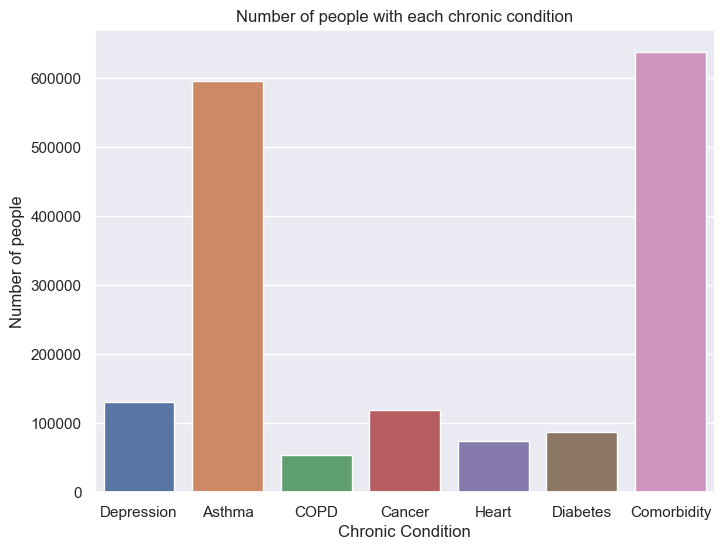

In [94]:
# Group the data by chronic condition and count the number of people with each condition
condition_counts = df[['Depression', 'Asthma', 'COPD', 'Cancer', 'Heart', 'Diabetes', 'Comorbidity']].sum()

# Plot the data as a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=condition_counts.index, y=condition_counts.values)
plt.xlabel('Chronic Condition')
plt.ylabel('Number of people')
plt.title('Number of people with each chronic condition')
plt.show()




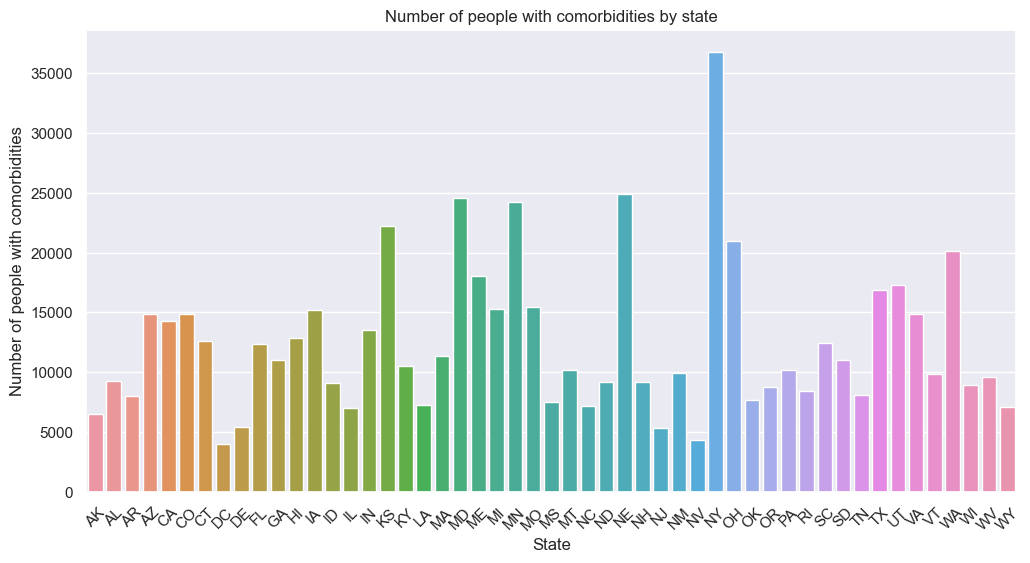

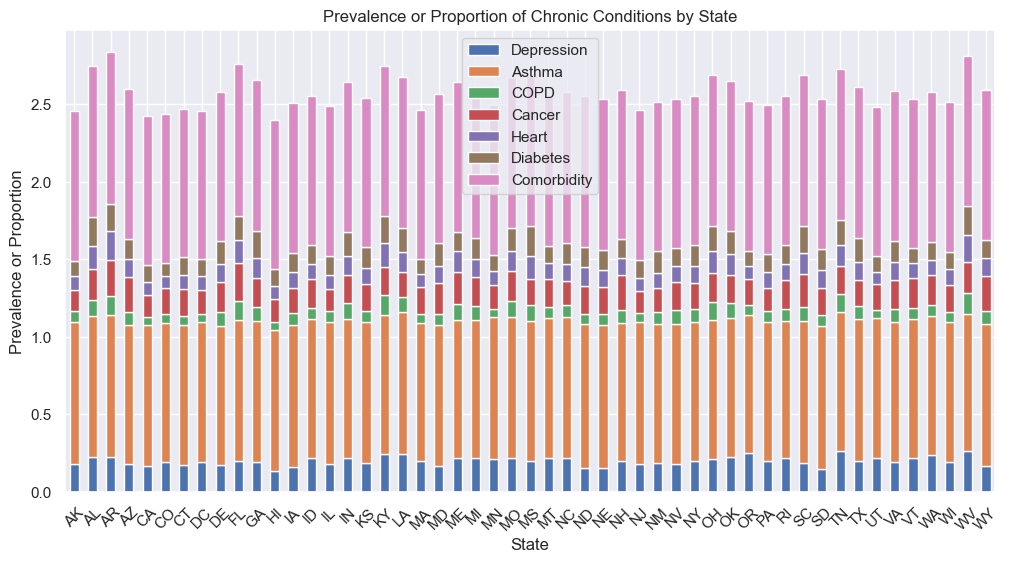

In [131]:
# Define a dictionary to map state numbers to state initials
state_dict = {1: 'AL', 2: 'AK', 4: 'AZ', 5: 'AR', 6: 'CA', 8: 'CO', 9: 'CT', 10: 'DE', 11: 'DC', 12: 'FL',
              13: 'GA', 15: 'HI', 16: 'ID', 17: 'IL', 18: 'IN', 19: 'IA', 20: 'KS', 21: 'KY', 22: 'LA',
              23: 'ME', 24: 'MD', 25: 'MA', 26: 'MI', 27: 'MN', 28: 'MS', 29: 'MO', 30: 'MT', 31: 'NE',
              32: 'NV', 33: 'NH', 34: 'NJ', 35: 'NM', 36: 'NY', 37: 'NC', 38: 'ND', 39: 'OH', 40: 'OK',
              41: 'OR', 42: 'PA', 44: 'RI', 45: 'SC', 46: 'SD', 47: 'TN', 48: 'TX', 49: 'UT', 50: 'VT',
              51: 'VA', 53: 'WA', 54: 'WV', 55: 'WI', 56: 'WY'}

# Create a new column called 'State Initials' that maps the state numbers to state initials
df['State Initials'] = df['_STATE'].map(state_dict)

# Group the data by state initials and count the number of people with comorbidities
comorbidity_counts = df.groupby('State Initials')['Comorbidity'].sum()

# Plot the data as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=comorbidity_counts.index, y=comorbidity_counts.values)
plt.xlabel('State')
plt.ylabel('Number of people with comorbidities')
plt.title('Number of people with comorbidities by state')
plt.xticks(rotation=45)
plt.show()


#Repeat by mean
by_state = df.groupby('State Initials')[["Depression", "Asthma", "COPD", "Cancer", "Heart", "Diabetes", "Comorbidity"]].mean()

# Plot the data as a stacked bar chart
by_state.plot(kind="bar", stacked=True, figsize=(12, 6))

# Add labels and title
plt.xlabel("State")
plt.ylabel("Prevalence or Proportion")
plt.title("Prevalence or Proportion of Chronic Conditions by State")
plt.xticks(rotation=45)

# Show the plot
plt.show()

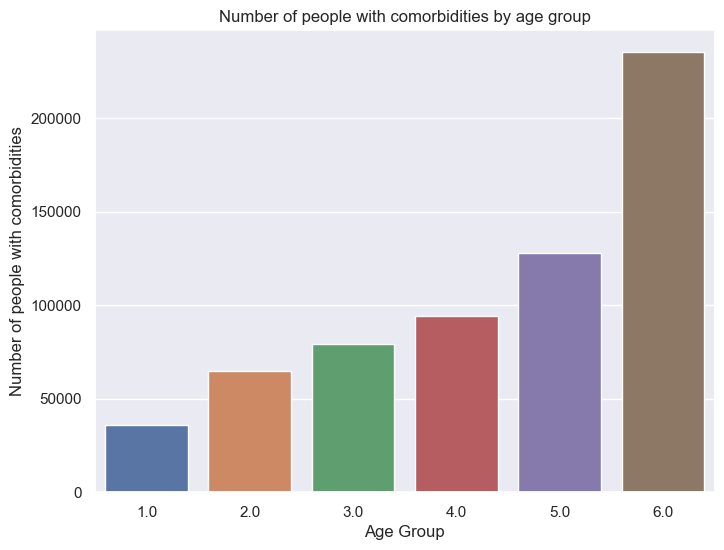

In [90]:
# Group the data by age group and count the number of people with comorbidities
age_comorbidity_counts = df.groupby('_AGE_G')['Comorbidity'].sum()

# Plot the data as a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=age_comorbidity_counts.index, y=age_comorbidity_counts.values)
plt.xlabel('Age Group')
plt.ylabel('Number of people with comorbidities')
plt.title('Number of people with comorbidities by age group')
plt.show()


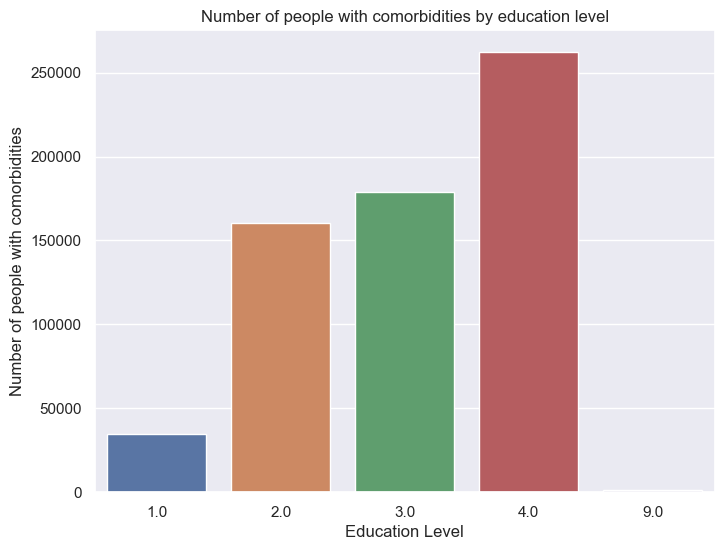

In [91]:
# Group the data by education level and count the number of people with comorbidities
education_comorbidity_counts = df.groupby('_EDUCAG')['Comorbidity'].sum()

# Plot the data as a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=education_comorbidity_counts.index, y=education_comorbidity_counts.values)
plt.xlabel('Education Level')
plt.ylabel('Number of people with comorbidities')
plt.title('Number of people with comorbidities by education level')
plt.show()

#### Histograms

<Figure size 1200x1200 with 0 Axes>

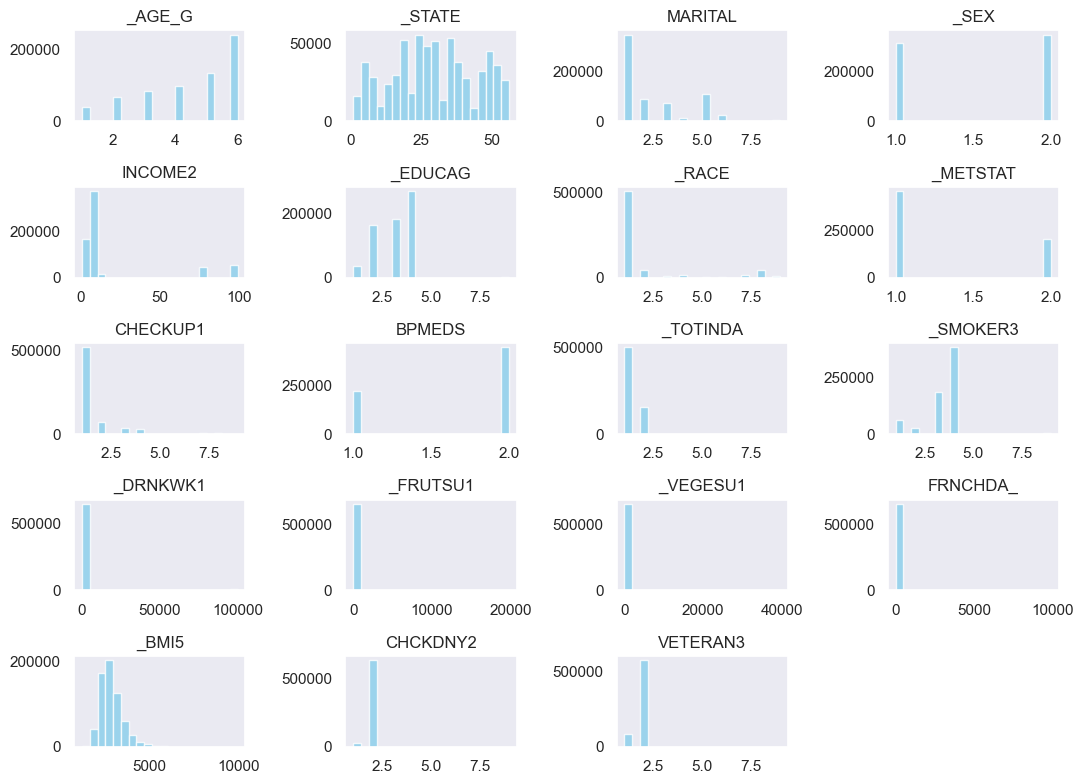

In [100]:
# Create a histogram grid of all the feature space variables
plt.figure(figsize=(12, 12))
df[feature_cols].hist(bins=20, color='skyblue', alpha=0.8, grid=False, edgecolor='white')
plt.tight_layout()
plt.show()


#### Heatmaps

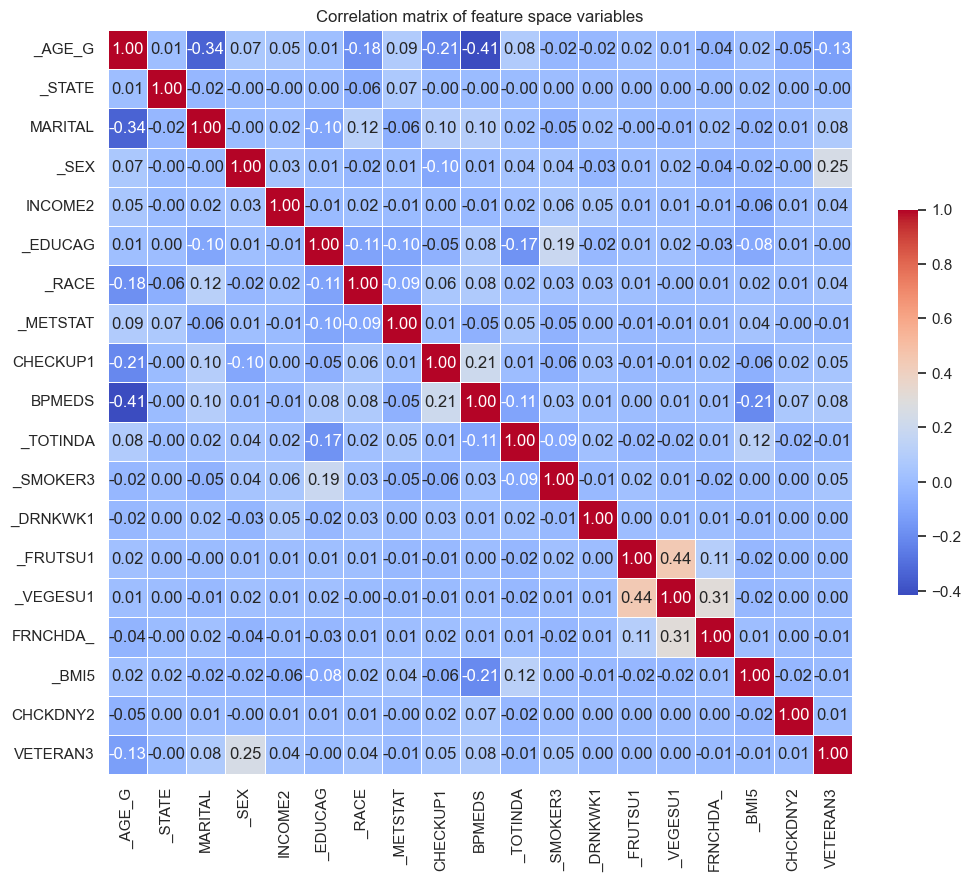

In [102]:
# Compute the correlation matrix of the feature space variables
corr_matrix = df[feature_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, square=True, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix of feature space variables')
plt.show()

#### Pair Plots

<Figure size 1500x1500 with 0 Axes>

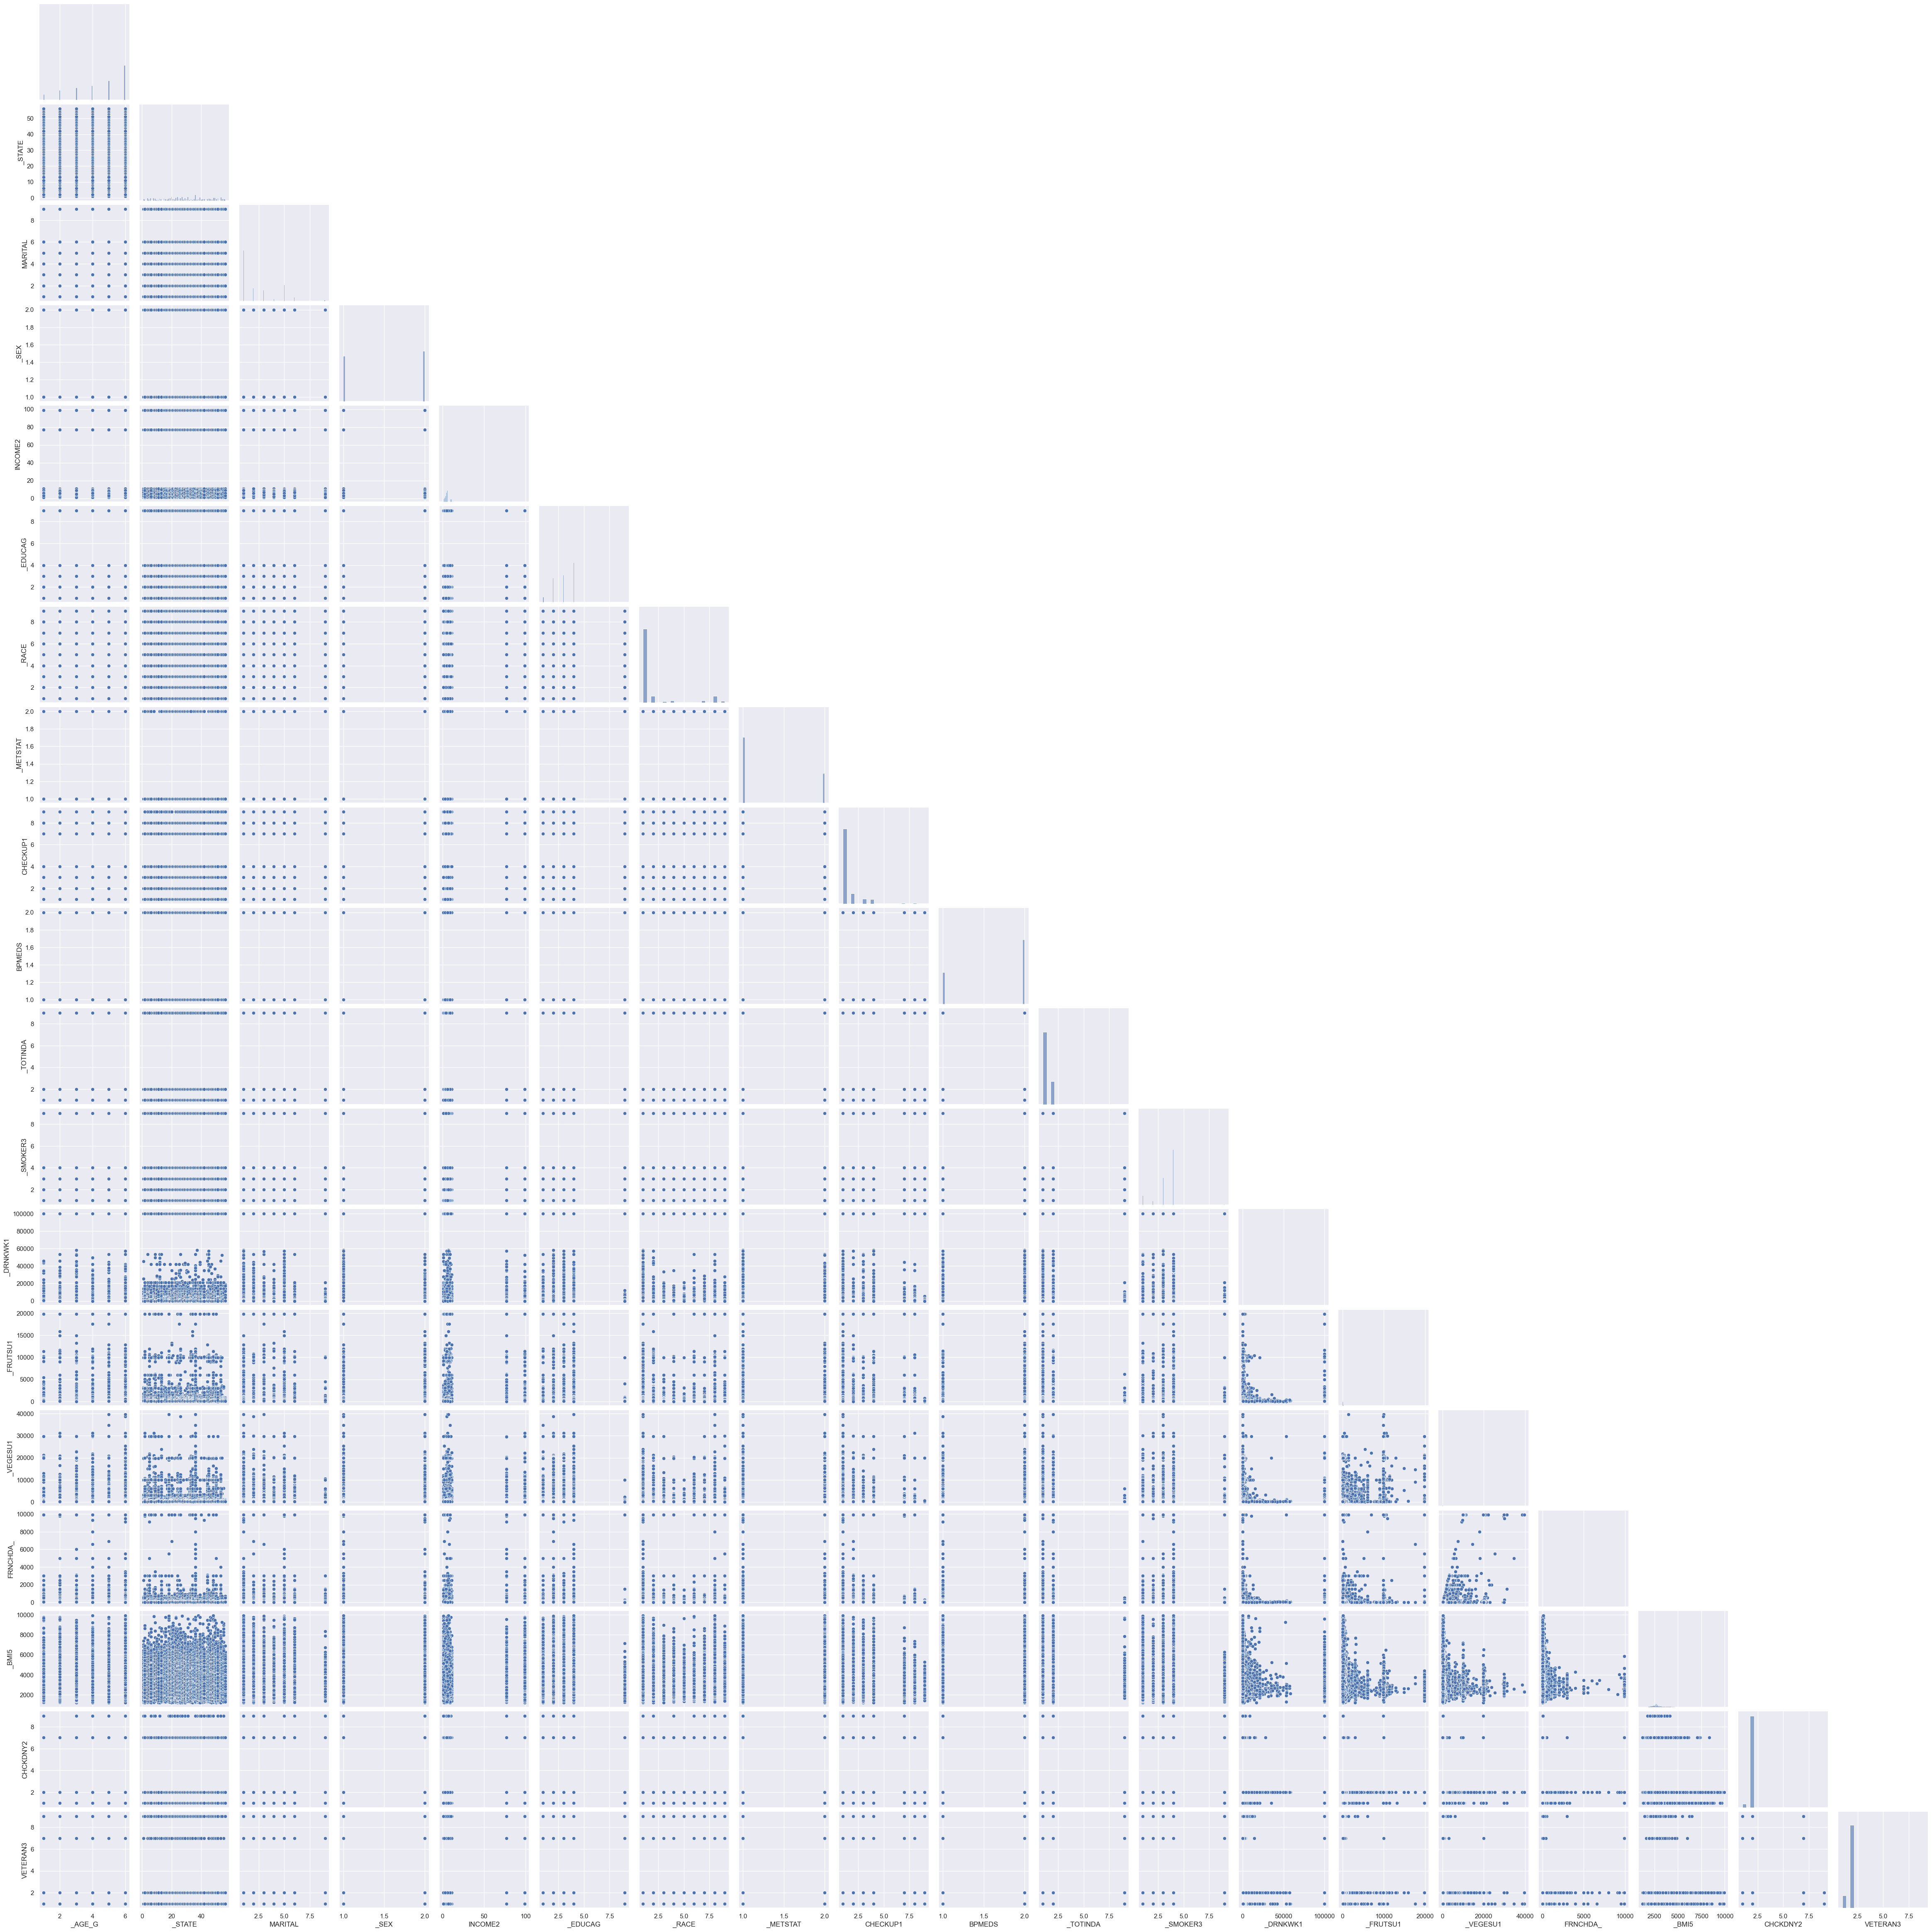

In [133]:
# Reset the index to create a new unique index
df = df.reset_index()

# Create a pair plot of all the variables in the feature space
plt.figure(figsize=(15, 15))
sns.pairplot(df[feature_cols], corner=True, diag_kind='hist', diag_kws=dict(alpha=0.6))
plt.show()

#### Crsstabs and Visualizations -- Results and Key Insights

While this is based on raw date vs means or averages, I think it is really interesting to review and fair when comparing comorbidity variables.

Depression:
- Higher prevalence in women (_SEX: 2.00) than in men (_SEX: 1.00).
- Prevalence decreases as income (INCOME2) increases.
- Prevalence is higher among divorced (MARITAL: 4.00) and separated (MARITAL: 5.00) individuals.
- Prevalence is lower among those with higher education (_EDUCAG: 4.00, 9.00).
- Prevalence is higher in younger age groups (_AGE_G: 1.00, 2.00) and decreases as age increases.
- Prevalence of depression varies across race, with non-Hispanic Black (2.00) and Hispanic (3.00) populations showing higher percentages compared to non-Hispanic White (1.00) and non-Hispanic Asian (4.00) populations.
- The prevalence of depression is similar in both metropolitan (20%) and non-metropolitan (20%) areas.
- The prevalence of depression is lowest among individuals who had their last routine checkup within the past year (20%) and highest among those who had their last checkup more than 5 years ago or never (15%).
- The prevalence of depression is slightly higher among individuals taking blood pressure medications (21%) compared to those who are not (19%).
- Individuals who are physically inactive have a higher prevalence of depression (26%) compared to those who are physically active (18%).
- The prevalence of depression is highest among current smokers (34%) and lowest among individuals who never smoked (16%).
- The prevalence of depression is relatively consistent across different levels of alcohol consumption, with only slight variations.
- The prevalence of depression is higher among individuals who have been screened for kidney disease (29%) compared to those who have not (19%).
- The prevalence of depression is lowest among veterans (16%) and highest among individuals with unknown veteran status (29%).

Asthma:
- Prevalence is consistent across age groups.
- Slightly higher prevalence among divorced (MARITAL: 4.00) individuals.
- Prevalence is relatively consistent across states, with minor variations.
- Asthma prevalence is higher among individuals with lower income levels (INCOME2).
- Asthma prevalence is lower among those with higher education levels (_EDUCAG: 4.00, 9.00).
- Asthma prevalence is slightly higher in non-metropolitan areas (9% without Asthma) compared to metropolitan areas (10% without Asthma).
- Checkup frequency (CHECKUP1): Asthma prevalence is higher among those who had a checkup within the past year (10% without Asthma) compared to those who had a checkup 2-5 years ago (8% without Asthma) or more than 5 years ago (7% without Asthma).
- Asthma prevalence is slightly higher among those who are not taking blood pressure medication (9% without Asthma) compared to those who are taking it (11% without Asthma).
- Asthma prevalence is lower among those who are physically active (9% without Asthma) compared to those who are inactive (12% without Asthma).
- Asthma prevalence is highest among current smokers (13% without Asthma) and lowest among never smokers (9% without Asthma).
- Asthma prevalence tends to be slightly lower among those who consume higher amounts of alcohol weekly.
- Asthma prevalence is higher among those who have not had their kidney function checked (16% without Asthma) compared to those who have (9% without Asthma).
- Asthma prevalence is lowest among veterans (6% without Asthma)

COPD:
- The prevalence of COPD increases with age, from 2% in the youngest age group to 12% in the oldest age group.
- The prevalence of COPD is higher among divorced (15%), separated (13%), and widowed (14%) individuals compared to married (6%), never married (5%), or unmarried couples (6%).
- COPD prevalence varies across states, with some states having a higher prevalence than others (e.g., 12% in state Idaho).
- COPD prevalence is slightly higher among females (9%) than males (7%).
- COPD prevalence generally decreases with increasing income levels, from 19% in the lowest income category to 2% in the highest income category.
- The prevalence of COPD decreases with increasing education levels, from 17% among those with less than high school education to 4% among those with college education or higher.
- COPD prevalence varies across racial groups, with the highest prevalence among individuals identifying as "Other race" (11%) and the lowest among Asian individuals (2%).
- COPD prevalence is slightly higher among individuals living in non-metropolitan areas (10%) compared to those in metropolitan areas (7%).
- COPD prevalence is slightly higher among individuals who have not had a checkup within the past year (9%) compared

Cancer:
- Cancer prevalence is higher among divorced (0.32) and widowed (0.19) individuals compared to married (0.19) or single (0.19) individuals.
- Cancer prevalence varies across states, with the highest prevalence in states like 12.00 (0.24) and 5.00 (0.24), and the lowest in states like 6.00 (0.14) and 2.00 (0.14).
- Cancer prevalence is slightly higher in females (0.19) compared to males (0.17).
- Cancer prevalence decreases as income levels increase, with the highest prevalence in the lowest income category (0.14) and the lowest in the highest income category (0.14).
- Cancer prevalence is slightly higher among those with less education (0.15 for the lowest education category) compared to those with higher education (0.19 for the highest education category).
- Cancer prevalence is the highest among White individuals (0.21) and the lowest among Asian individuals (0.05).
- Cancer prevalence increases with age, with the highest prevalence in the oldest age group (0.66) and the lowest in the youngest age group (0.01).

Heart conditions:
- As age increases, the proportion of individuals with heart conditions increases as well. The percentage of individuals with heart conditions is lowest for the youngest age group (1.00) and highest for the oldest age group (6.00).
- Marital status seems to have some association with heart conditions. The percentage of individuals with heart conditions is highest for those who are widowed (3.00), while the percentage is lowest for those who are married (1.00) and never married (6.00).
- The prevalence of heart conditions varies across states, with some states showing a higher percentage of individuals with heart conditions compared to others. However, it's essential to consider other factors, such as age distribution, socioeconomic status, and lifestyle factors, when comparing states.
- Males (1.00) have a slightly higher percentage of heart conditions compared to females (2.00).
- As income increases, the percentage of individuals with heart conditions decreases. The highest percentage of individuals with heart conditions is found in the lowest income group (1.00), while the lowest percentage is in the highest income group (11.00).
- Higher education levels are associated with a lower percentage of individuals with heart conditions. The highest percentage of individuals with heart conditions is found in the lowest education group (1.00), while the lowest percentage is in the highest education group (4.00).
- The percentage of individuals with heart conditions varies by race. The highest percentage is found among white

Diabetes:
- As age increases, the proportion of individuals with diabetes increases. The percentage of individuals with diabetes is lowest for the youngest age group (1.00) and highest for the oldest age group (6.00)
- Marital status seems to have some association with diabetes. The percentage of individuals with diabetes is highest for those who are widowed (3.00) and divorced/separated (2.00), while the percentage is lowest for those who are never married (6.00).
- The prevalence of diabetes varies across states. However, it's essential to consider other factors, such as age distribution, socioeconomic status, and lifestyle factors, when comparing states.
- Males (1.00) have a slightly higher percentage of diabetes compared to females (2.00).
- As income increases, the percentage of individuals with diabetes decreases. The highest percentage of individuals with diabetes is found in the lowest income group (1.00), while the lowest percentage is in the highest income group (11.00).
- Higher education levels are associated with a lower percentage of individuals with diabetes. The highest percentage of individuals with diabetes is found in the lowest education group (1.00), while the lowest percentage is in the highest education group (4.00).

Comorbidity:
- As age increases, the proportion of individuals with at least one comorbidity also increases, with the highest percentage found among the oldest age group (6.00).
- Individuals who are widowed (5.00) or divorced/separated (3.00) have a slightly higher percentage of comorbidities compared to those who are never married (1.00).
- The prevalence of comorbidities varies across states. A more in-depth analysis, considering other factors such as age distribution, socioeconomic status, and lifestyle factors, is needed for a comprehensive comparison.
- Males (1.00) have a slightly higher percentage of comorbidities compared to females (2.00).
- As income increases, the percentage of individuals with comorbidities decreases, with the highest percentage found in the lowest income group (1.00) and the lowest percentage in the highest income group (11.00).
- Education (_EDUCAG): Higher education levels are associated with a lower percentage of comorbidities. The highest percentage is found in the lowest education group (1.00), while the lowest percentage is in the highest education group (4.00).
- Non-Hispanic Black (2.00) and Hispanic (3.00) populations have a higher percentage of comorbidities compared to non-Hispanic White (1.00) and non-Hispanic Asian (4.00) populations.




### Summary of Salient features of the healthiest and least health states:

The question can be best analyzed by the following pivot table and bar chart. We are going to somewhat broadly and inaccurately definer health as a presence of comorbidities. The chronic conditions include Asthma, COPD (Chronic Obstructive Pulmonary Disease), Cancer, Depression, Diabetes, and Heart diseases. The Comorbidity_mean column represents the average prevalence of comorbidities (presence of two or more chronic conditions) in each state.

States with the highest comorbidity rates:

Alabama (AL) - 0.98
Arkansas (AR) - 0.98
Florida (FL) - 0.98

Salient features of states with the highest comorbidity presence (AL and AR):

Both states have high prevalence rates for Asthma (0.91), COPD (0.10 for AL, 0.12 for AR), and Cancer (0.20 for AL, 0.24 for AR).
They have high rates of depression (0.23) and diabetes (0.18).
The use of blood pressure medication (BPMEDS) is relatively high, with rates of 1.56 for AL and 1.53 for AR.
Both states have a high frequency of checkups (1.34 for AL, 1.33 for AR) and kidney disease screening (CHCKDNY2) rates of 1.97.
Consumption of French fries (FRNCHDA_) is notably high in AR (38.59) compared to AL (23.49).
Average educational attainment (_EDUCAG) is relatively low, with 2.93 for AL and 2.87 for AR.

States with the lowest comorbidity rates:

Rhode Island (RI) - 0.96
Arizona (AZ) - 0.96
California (CA) - 0.96

Both states have lower prevalence rates for Asthma (0.91 for CA, 0.88 for RI), COPD (0.05 for CA, 0.08 for RI), and Cancer (0.14 for CA, 0.19 for RI).
Depression rates are relatively lower, with 0.16 for CA and 0.22 for RI, as are diabetes rates, with 0.11 for CA and 0.12 for RI.
The use of blood pressure medication (BPMEDS) is higher in these states, with rates of 1.77 for CA and 1.66 for RI.
The frequency of checkups (CHECKUP1) is higher in CA (1.54) and lower in RI (1.23) compared to the highest comorbidity states, while kidney disease screening (CHCKDNY2) rates are similar (1.97 for CA and 1.98 for RI).
Consumption of French fries (FRNCHDA_) is lower in both states, with 18.76 for CA and 21.90 for RI.


In [156]:
# Group the data by state and compute the mean value for each variable
mean_values_per_state = df.groupby('State Initials').mean()

# Create a pivot table with State Initials as the index and the mean values for each variable
# Isolated variables
# pivot_table = pd.pivot_table(mean_values_per_state, values=['Comorbidity', 'Depression', 'Asthma', 'COPD', 'Cancer', 'Heart', 'Diabetes'], index=['State Initials'])
#WHole set

pivot_table = pd.pivot_table(mean_values_per_state, values=['Comorbidity', 'Depression', 'Asthma', 'COPD', 'Cancer', 'Heart', 'Diabetes', '_AGE_G', '_STATE', 'MARITAL', '_SEX', 'INCOME2', '_EDUCAG', '_RACE', '_METSTAT', 'CHECKUP1', 'BPMEDS', '_TOTINDA', '_SMOKER3', '_DRNKWK1', '_FRUTSU1', '_VEGESU1', 'FRNCHDA_', '_BMI5', 'CHCKDNY2', 'VETERAN3'], index=['State Initials'])

# Print the pivot table
print(pivot_table)


                Asthma  BPMEDS  CHCKDNY2  CHECKUP1  COPD  Cancer  Comorbidity  \
State Initials                                                                  
AK                0.91    1.73      1.98      1.66  0.07    0.14         0.97   
AL                0.91    1.56      1.97      1.34  0.10    0.20         0.98   
AR                0.91    1.53      1.96      1.33  0.12    0.24         0.98   
AZ                0.90    1.68      1.96      1.47  0.09    0.22         0.96   
CA                0.91    1.77      1.97      1.54  0.05    0.14         0.96   
CO                0.90    1.77      1.98      1.57  0.06    0.17         0.96   
CT                0.90    1.69      1.98      1.32  0.06    0.17         0.96   
DC                0.90    1.70      1.98      1.36  0.05    0.15         0.96   
DE                0.90    1.65      1.96      1.33  0.09    0.19         0.96   
FL                0.91    1.63      1.97      1.41  0.12    0.24         0.98   
GA                0.91    1.

### Associate Factors when comparing year by year. 

Comparing the data from 2019 and 2021, the comorbidity rates remain stable at 0.97. However, there are some notable differences and insights across various health-related factors and demographic indicators:

Age: The average age (_AGE_G) slightly decreased from 4.46 in 2019 to 4.39 in 2021, indicating a slightly younger population.

Marital Status: There was a small increase in marital status (MARITAL) from 2.29 in 2019 to 2.33 in 2021, suggesting a potential shift in the distribution of marital statuses.

Income: Average income (INCOME2) increased from 17.69 in 2019 to 19.63 in 2021, which could be attributed to economic growth or changes in the distribution of incomes.

Education: The average educational attainment (_EDUCAG) increased from 3.03 in 2019 to 3.09 in 2021, suggesting an improvement in education levels.

Race: The racial diversity (_RACE) increased slightly from 1.93 in 2019 to 2.01 in 2021.

Checkups: The frequency of checkups (CHECKUP1) increased slightly from 1.41 in 2019 to 1.44 in 2021, suggesting that people may be seeking more regular healthcare.

Blood Pressure Medication: The use of blood pressure medication (BPMEDS) remained stable at 1.67 in both 2019 and 2021.

Physical Activity: The level of total physical activity (_TOTINDA) decreased slightly from 1.27 in 2019 to 1.24 in 2021, indicating that people may be engaging in less physical activity.

Smoking: The smoking rate (_SMOKER3) increased marginally from 3.36 in 2019 to 3.40 in 2021.

Alcohol Consumption: Average alcohol consumption per week (_DRNKWK1) decreased from 1759.10 in 2019 to 1729.99 in 2021.

Fruit and Vegetable Consumption: There was a significant increase in fruit (_FRUTSU1) consumption from 144.86 in 2019 to 176.48 in 2021, and vegetable (_VEGESU1) consumption from 205.75 in 2019 to 270.08 in 2021.

French Fries Consumption: There was an increase in French fries consumption (FRNCHDA_) from 21.81 in 2019 to 25.38 in 2021, indicating a higher preference for this type of food.

BMI: The average BMI (_BMI5) slightly increased from 2835.83 in 2019 to 2858.08 in 2021, suggesting a potential rise in obesity or overweight prevalence.

Kidney Disease Screening: The kidney disease screening (CHCKDNY2) rates remained the same at 1.97 for both 2019 and 2021.

Veteran Status: The veteran status (VETERAN3) remained almost the same, with a slight increase from 1.87 in 2019 to 1.88 in 2021.

Depression: Depression rates increased marginally from 0.19 in 2019 to 0.20 in 2021.

Asthma: The prevalence of asthma decreased slightly from 0.91 in 2019 to 0.90 in 2021.

COPD: The prevalence of COPD remained stable at 0.08 for both 2019 and 2021.

Cancer: The cancer prevalence rate decreased from 0.19 in 2019 to 0.17 in 2021.

Heart: The heart condition prevalence rate decreased from 0.12 in 2019 to 0.11 in 2021.

In [177]:
# Create a new column called 'State Initials' that maps the state numbers to state initials
df_21_trim['State Initials'] = df_21_trim['_STATE'].map(state_dict)
df_19_trim['State Initials'] = df_19_trim['_STATE'].map(state_dict)


# For df_21_trim
mean_values_21 = df_21_trim.groupby('State Initials').mean()
pivot_table_21 = pd.pivot_table(mean_values_21, values=['Comorbidity', 'Depression', 'Asthma', 'COPD', 'Cancer', 'Heart', 'Diabetes', '_AGE_G', '_STATE', 'MARITAL', '_SEX', 'INCOME2', '_EDUCAG', '_RACE', '_METSTAT', 'CHECKUP1', 'BPMEDS', '_TOTINDA', '_SMOKER3', '_DRNKWK1', '_FRUTSU1', '_VEGESU1', 'FRNCHDA_', '_BMI5', 'CHCKDNY2', 'VETERAN3'], index=['State Initials'])
print(pivot_table_21)

# For df_19_trim
#print(df_19_trim.columns)
mean_values_19 = df_19_trim.groupby('State Initials').mean()
pivot_table_19 = pd.pivot_table(mean_values_19, values=['Comorbidity', 'Depression', 'Asthma', 'COPD', 'Cancer', 'Heart', 'Diabetes', '_AGE_G', '_STATE', 'MARITAL', '_SEX', 'INCOME2', '_EDUCAG', '_RACE', '_METSTAT', 'CHECKUP1', 'BPMEDS', '_TOTINDA', '_SMOKER3', '_DRNKWK1', '_FRUTSU1', '_VEGESU1', 'FRNCHDA_', '_BMI5', 'CHCKDNY2', 'VETERAN3'], index=['State Initials'])
print(pivot_table_19)

                Asthma  BPMEDS  CHCKDNY2  CHECKUP1  COPD  Cancer  Comorbidity  \
State Initials                                                                  
AK                0.92    1.73      1.98      1.70  0.07    0.14         0.97   
AL                0.90    1.56      1.97      1.34  0.10    0.20         0.97   
AR                0.92    1.52      1.96      1.33  0.12    0.24         0.98   
AZ                0.90    1.70      1.96      1.50  0.08    0.21         0.97   
CA                0.91    1.77      1.98      1.62  0.05    0.14         0.96   
CO                0.90    1.79      1.98      1.60  0.06    0.15         0.96   
CT                0.89    1.72      1.98      1.38  0.06    0.15         0.96   
DC                0.90    1.71      1.98      1.41  0.05    0.15         0.95   
DE                0.90    1.65      1.96      1.36  0.08    0.19         0.96   
GA                0.91    1.58      1.95      1.37  0.09    0.19         0.97   
HI                0.92    1.

In [178]:
# Calculate mean values for each year
mean_values_19 = df_19_trim.mean()
mean_values_21 = df_21_trim.mean()

# Combine mean values for each year into a DataFrame
df_comparison = pd.DataFrame({'2019': mean_values_19, '2021': mean_values_21})

# Print the DataFrame
print(df_comparison)


               2019    2021
_AGE_G         4.46    4.39
MARITAL        2.29    2.33
_SEX           1.53    1.52
INCOME2       17.69   19.63
_EDUCAG        3.03    3.09
_RACE          1.93    2.01
_STATE        28.84   30.03
_METSTAT       1.31    1.31
CHECKUP1       1.41    1.44
BPMEDS         1.67    1.67
_TOTINDA       1.27    1.24
_SMOKER3       3.36    3.40
_DRNKWK1    1759.10 1729.99
_FRUTSU1     144.86  176.48
_VEGESU1     205.75  270.08
FRNCHDA_      21.81   25.38
_BMI5       2835.83 2858.08
CHCKDNY2       1.97    1.97
VETERAN3       1.87    1.88
Depression     0.19    0.20
Asthma         0.91    0.90
COPD           0.08    0.08
Cancer         0.19    0.17
Heart          0.12    0.11
Diabetes       0.14    0.13
Comorbidity    0.97    0.97


## Analysis 2
1. Using only 2021, use several classification algorithms to classify comorbility variables 1 and 2:
- Logistic Regression
- KNN
- RF
- Gradient Boosting
- XGBoost
- Catboost

2. Write a short report describing the performance metrics. 
3. In the end, choose one model each for the classification of both categorical variables

### Logistic Regresison

### KNN

### Random Forest

### Gradient Boost

### XGBoost

### Catboost